Implementation of Loop memory neural networks

Refer to PDF attached

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_grid(grid):
    '''
    Plot Grid defined by square grid of points and connection beetween poins given as either one or zero.
    '''
    height, width, _ = grid.shape
    
    plt.figure(figsize=(width, height))
    ax = plt.gca()
    
    # Iterate through each point in the grid
    for y in range(height):
        for x in range(width):
            point = grid[y, x]
            
            # Coordinates
            x_coord, y_coord = point[0], point[1]
            
            # Edges for first nearest neighbour: Up, Down, Left, Right
            edges = point[2:6]
            
            # Draw line for each edge if present
            if edges[0]:  # Up
                plt.plot([x_coord, x_coord], [y_coord, y_coord + 0.5], 'k-')
            if edges[1]:  # Down
                plt.plot([x_coord, x_coord], [y_coord, y_coord - 0.5], 'k-')
            if edges[2]:  # Left
                plt.plot([x_coord, x_coord - 0.5], [y_coord, y_coord], 'k-')
            if edges[3]:  # Right
                plt.plot([x_coord, x_coord + 0.5], [y_coord, y_coord], 'k-')

            if len(point) > 6:
            # Edges for second nearest neighbour: Up, Down, Left, Right
                edges = point[6:]
            
                # Draw line for each edge if present
                if edges[0]:  # Up-right
                    plt.plot([x_coord, x_coord + 0.5], [y_coord , y_coord + 0.5], 'k-')
                if edges[1]:  # Down-left
                    plt.plot([x_coord, x_coord - 0.5], [y_coord , y_coord - 0.5], 'k-')
                if edges[2]:  # Up-left
                    plt.plot([x_coord , x_coord - 0.5], [y_coord, y_coord + 0.5], 'k-')
                if edges[3]:  # Down-Right
                    plt.plot([x_coord , x_coord + 0.5], [y_coord, y_coord - 0.5], 'k-')
    
    ax.set_aspect('equal')
    plt.axis('off')
    plt.show()

In [3]:
class Grid:
    '''
    Initialise the square Grid points with parameters:
    Height, Weight, Neigghbours, activity

    Neighbours: either one or two, One means connection between grid points in four sides of square and two means connections between diagnols also.

    Activity: float between (0-4 for 1 neighbour) and (0-8 for 2 neighbour)  Total probability assigned at each grid point, representing number number of active connections when current flows.
              Probabilites are randomly assigned to each connection on grid with total of all being Activity.
    '''
    def __init__(self, width, height, neighbours = 1, activity = 2):
        self.neighbours = neighbours
        self.activity = activity

        if self.neighbours == 2:
            self.grid = np.zeros((height, width, 10), dtype=float)
        else :
            self.grid = np.zeros((height, width, 6), dtype=float)
            
        self._setup_grid()
        

    def _setup_grid(self):
        height, width, _ = self.grid.shape
        
        for y in range(height):
            for x in range(width):
                self.grid[y, x, 0] = x  # X coordinate
                self.grid[y, x, 1] = y  # Y coordinate

                total_propability = self.activity

                if self.neighbours == 2:  
                    # Generate random probabilities that sum to 1
                    probabilities = np.random.dirichlet(np.ones(8), size=1)[0]*total_propability
                    self.grid[y, x, 2:10] = probabilities

                else :
                    # Generate random probabilities that sum to 1
                    probabilities = np.random.dirichlet(np.ones(4), size=1)[0]*total_propability
                    self.grid[y, x, 2:6] = probabilities

Example of a grid with 10 X 5 dimention and 2 neighbours

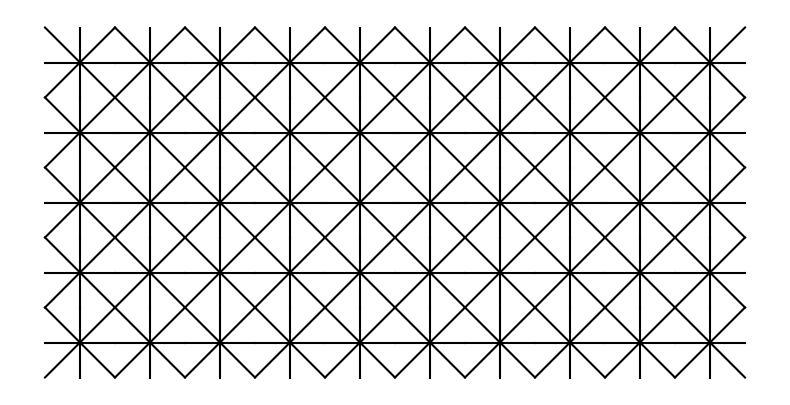

In [4]:
grid = Grid(10, 5, neighbours = 2, activity = 4)
plot_grid(grid.grid)

In [5]:
def probability_collapse(grid_instance):
    '''
    Take the Grid with defined probabilities, and give new grid with active synapses only,
    Active synapse are calculated based of their probability defined.
    eg if synapse has probability 0.8 then there is 80% of it being active.
    '''
    height, width, depth = grid_instance.shape
    new_grid = np.zeros((height, width, depth), dtype=int)  # New grid with (x, y, assigned_value)

    for y in range(height):
        for x in range(width):
            x_coord = int(grid_instance[y, x, 0])
            y_coord = int(grid_instance[y, x, 1])

            # Determine the range of probabilities based on the 'neighbours' attribute
            prob_start_index = 2
            prob_end_index = depth

            # Extract probabilities
            probabilities = grid_instance[y, x, prob_start_index:prob_end_index]

            # Initialize an empty list to accumulate assigned values based on probabilities
            collapsed = []

            # Assign 1 or 0 based on each probability and append to 'collapsed'
            for prob in probabilities:
                assigned_value = 1 if np.random.rand() <= prob else 0
                collapsed.append(assigned_value)

            # Convert 'collapsed' to a NumPy array and store it in the new grid
            new_grid[y, x, 0] = x_coord
            new_grid[y, x, 1] = y_coord
            new_grid[y, x, 2:prob_end_index] = np.array(collapsed)

    return new_grid

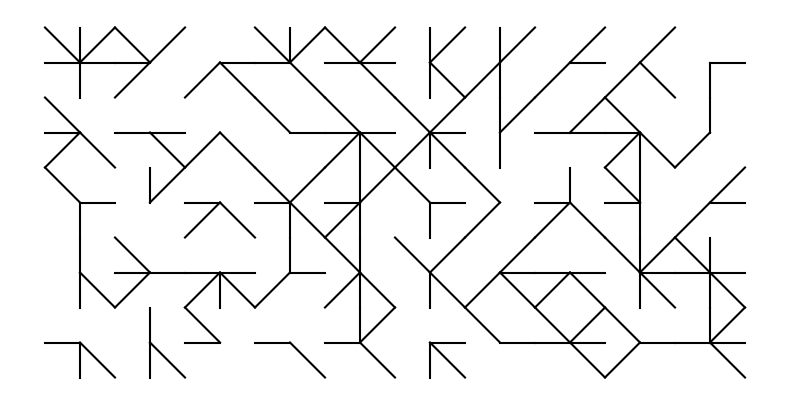

In [6]:
# eg of plot after probability collapse
grid = Grid(10, 5, neighbours = 2, activity = 4)
plot_grid(probability_collapse(grid.grid))

In [7]:
def modify_probability(grid, instance, learning_rate):
    '''
    Given a grid probablilies, collapse grid instance and learning rate (0-100),
    Gives new grid probabilities.
    '''
    height, width, depth = grid.shape

    for y in range(height):
        for x in range(width):
            x_coord = int(grid[y, x, 0])
            y_coord = int(grid[y, x, 1])

            # Determine the range of probabilities based on the 'neighbours' attribute
            prob_start_index = 2
            prob_end_index = depth

            total_synapse = depth - 2
            active_synapse = np.sum(instance[y,x,2:])

            for i in range (depth - 2):
                if instance[y, x, i+2] ==1:
                    if active_synapse == 0:
                        pass
                    else:
                        grid[y, x, i+2] = grid[y, x, i+2]*(1+ (learning_rate/100)/active_synapse)
                else :
                    if active_synapse == 0:
                        pass
                    else:
                        grid[y, x, i+2] = grid[y, x, i+2]*(1- (learning_rate/100)/active_synapse)
    return grid

In [8]:
class Simulator:
    '''
    Simulate the learning in network, with modify probability in each step and 5 step history rembered in in modify step to give past state memory.

    grid: Grid with probabiliest of synapse

    Activation: List of Grid with synapse being 0 or 1, length of list must be number of itteration.
                we no activation is provided in anystep of activation pass grid of all zeros

    Itteration: Number of steps in learning

    Retain_rate: Expontial constant of how past state grid memory is being decayed in learing step

    Learning rate: Effect of activation on grid probabilities
    '''
    def __init__(self, grid, activation, itteration=10, retain_rate=0.5, learning_rate=10):
        self.grid = grid
        self.activation = activation
        self.itteration = itteration
        self.retain_rate = retain_rate
        self.learning_rate = learning_rate
        self.instance_snap = []
        self.height = self.grid.shape[0]
        self.width = self.grid.shape[1]
        self.depth = self.grid.shape[2]
        self.snap_m2 = np.zeros((self.height, self.width, self.depth), dtype=float)
        self.snap_m3 = np.zeros((self.height, self.width, self.depth), dtype=float)
        self.snap_m4 = np.zeros((self.height, self.width, self.depth), dtype=float)
        self.snap_m5 = np.zeros((self.height, self.width, self.depth), dtype=float)
            
        self._simulate()

    def _simulate(self):
        for i in range(self.itteration):
            overlay = self.activation[i] + self.snap_m5 + self.snap_m4 + self.snap_m3 + self.snap_m2

            self.snap_m5 = self.snap_m4*(1/(1 + np.exp(-5*(self.retain_rate-1) )))
            self.snap_m4 = self.snap_m3*(1/(1 + np.exp(-5*(self.retain_rate-1) )))
            self.snap_m3 = self.snap_m2*(1/(1 + np.exp(-5*(self.retain_rate-1) )))
            self.snap_m2 = self.activation[i]*(1/(1 + np.exp(-5*(self.retain_rate-1) )))  

            old_grid = self.grid
            net_grid = old_grid + overlay
            
            instance = probability_collapse(net_grid)
            self.grid = modify_probability(net_grid, instance, self.learning_rate)
            self.instance_snap.append(instance)            

Example of 10 X 5 Grid with one neighbours, and null activation function

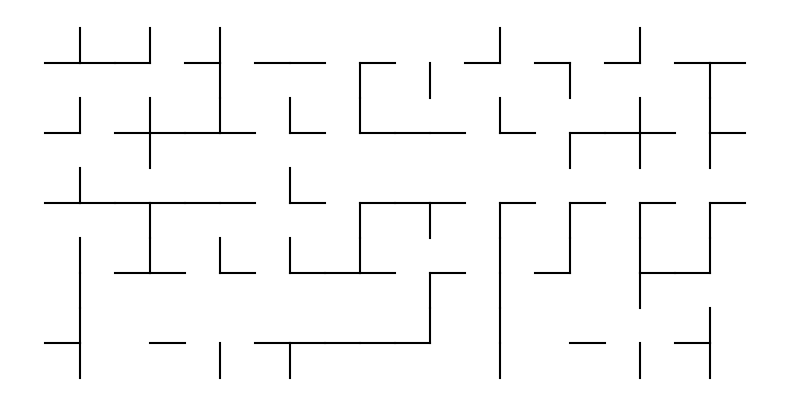

In [9]:
grid = Grid(10, 5, neighbours = 1, activity = 3)

activation_list = [np.zeros((5, 10, 6), dtype=float) for _ in range(15)]

first_sim = Simulator(grid.grid, activation_list, itteration=15, learning_rate=40, retain_rate=10)

plot_grid(first_sim.instance_snap[10])

Example of 10 X 5 Grid with two neighbours, and null activation function

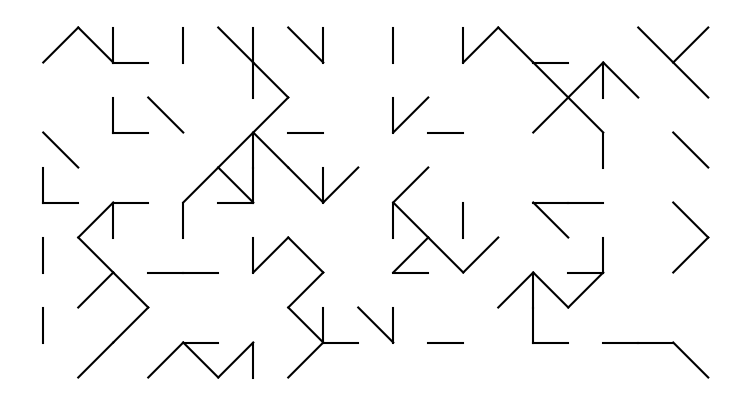

In [10]:
grid = Grid(10, 5, neighbours = 2, activity = 3)

activation_list = [np.zeros((5, 10, 10), dtype=float) for _ in range(15)]

first_sim = Simulator(grid.grid, activation_list, itteration=15, learning_rate=40, retain_rate=10)

plot_grid(first_sim.instance_snap[10])